In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def read_data(file_path):
    data = pd.read_csv(file_path)
    return data

data = read_data('./ai4i2020.csv')
print(data.iloc[:5, :]) 
print(data.shape)

   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0  

In [3]:
# 前两列是编号，中间6列是特征，最后5列是目标
data = data.iloc[:, 2:]
print(data.iloc[:5, :]) 

  Type  Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0    M                298.1                    308.6                    1551   
1    L                298.2                    308.7                    1408   
2    L                298.1                    308.5                    1498   
3    L                298.2                    308.6                    1433   
4    L                298.2                    308.7                    1408   

   Torque [Nm]  Tool wear [min]  Machine failure  TWF  HDF  PWF  OSF  RNF  
0         42.8                0                0    0    0    0    0    0  
1         46.3                3                0    0    0    0    0    0  
2         49.4                5                0    0    0    0    0    0  
3         39.5                7                0    0    0    0    0    0  
4         40.0                9                0    0    0    0    0    0  


In [4]:
class pt_feature():
    def __init__(self, data, axes_shape=(3, 2)):
        self.data = data
        self.i = 0
        self.j = 0
        self.axes_shape = axes_shape

    def plot_feature(self, axes, feature_name):
        i = self.i
        j = self.j
        x = self.data[feature_name].to_numpy()
        y_jitter = np.random.normal(0, 0.05, len(x))
        axes[i,j].scatter(x, y_jitter, alpha=0.5, s=30, c=x, cmap='coolwarm', edgecolors='black', linewidth=0.3, zorder=3)
        axes[i,j].axhline(y=0, color='red', linestyle='-', alpha=0.7, linewidth=1, zorder=2)
        axes[i,j].grid(True, alpha=0.3, zorder=1)
        axes[i,j].set_yticks([])
        axes[i,j].set_title(feature_name)
        axes[i,j].figure.tight_layout()
        if self.j == self.axes_shape[1] - 1:
            self.j = 0
            self.i += 1
        else:
            self.j += 1
        

In [5]:
data.dtypes[1:5].index

Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]'],
      dtype='object')

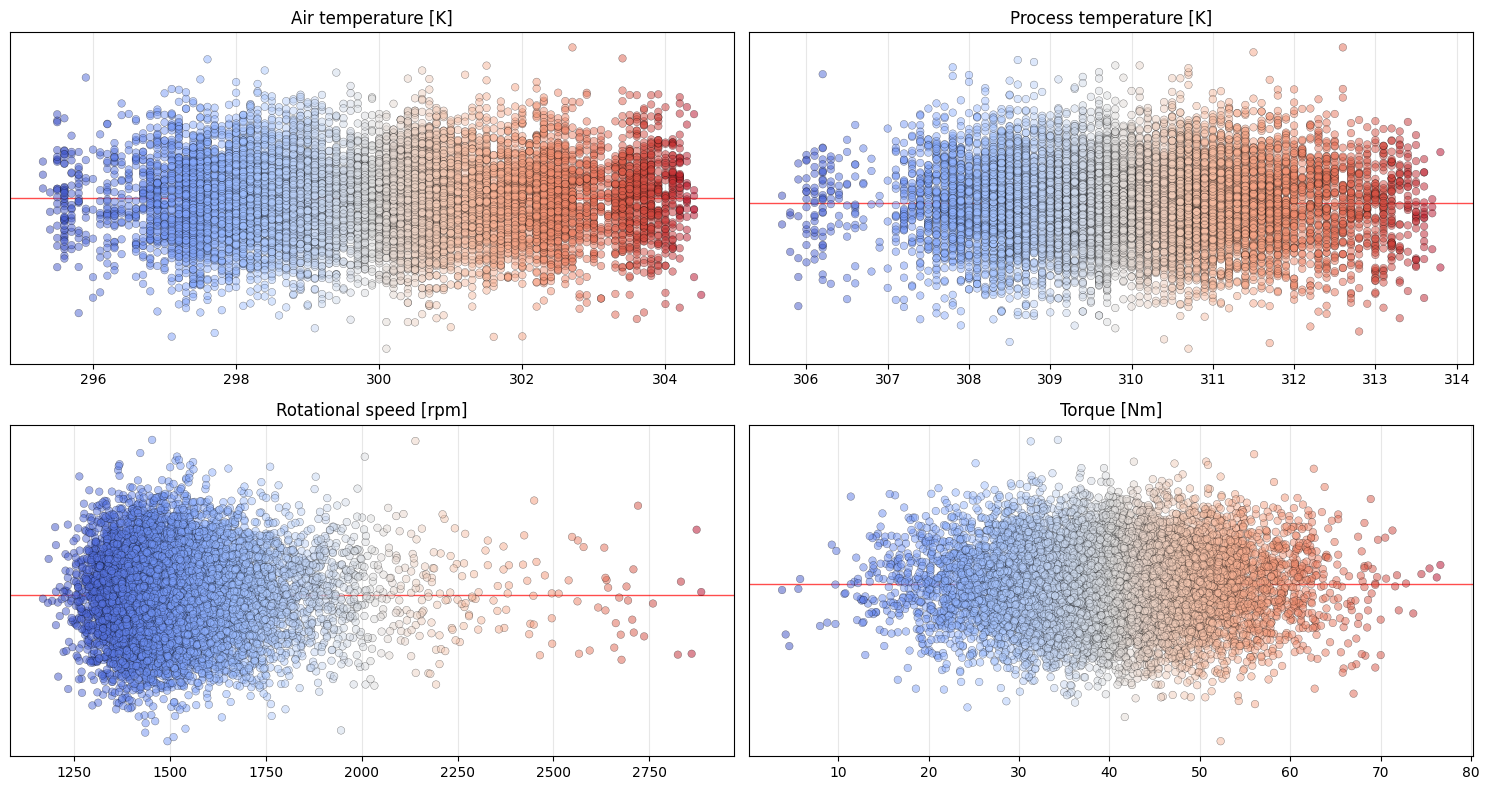

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(15, 8)) 
pt = pt_feature(data, axes_shape=axes.shape)
for col in data[data.dtypes[1:5].index]:
    name = col
    pt.plot_feature(axes, name)

In [16]:
cnt = 0
for rs, to in zip(data['Rotational speed [rpm]'], data['Torque [Nm]']):
    #print(rs, to)
    power = rs * to * np.pi * 2 / 60 
    if power < 3500 or power > 9000:
        cnt += 1
print("Count of PWF:", cnt)

Count of PWF: 95
